# Download Fashion MNIST Data

In [1]:
!mkdir -p ./data/fashion

In [2]:
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -o ./data/fashion/train-labels-idx1-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -o ./data/fashion/t10k-images-idx3-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -o ./data/fashion/t10k-labels-idx1-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -o ./data/fashion/train-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29515  100 29515    0     0   137k      0 --:--:-- --:--:-- --:--:--  137k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4318k  100 4318k    0     0  5852k      0 --:--:-- --:--:-- --:--:-- 5851k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0  62077      0 --:--:-- --:--:-- --:--:-- 62780
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  24.2M      0  0:00:01  0:00:01 --:--:-- 24.2M


# Import Packages

In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow  as tf
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [4]:
from sklearn.utils import shuffle

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Experiment Configuration

In [6]:
batch_size = 128
num_classes = 10
epochs = 100
w_l2 = 1e-4

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Data Loader function

In [8]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

## Load Data

In [9]:
x_train, y_train =load_mnist('./data/fashion', kind='train')
x_test, y_test = load_mnist('./data/fashion', kind='t10k')

## Normalize data

In [10]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Create Mixup Data

In [11]:
len_x_train = x_train.shape[0]

In [12]:
def get_mixup_data(x_train, y_train, alpha=0.1, prob50=False):
    
    x_mixup, y_mixup = shuffle(x_train, y_train)
    
    for i in range(len_x_train):
        lam = np.random.beta(alpha, alpha)
        #rand_idx = np.random.choice(len_x_train)
        x_mixup[i] = (lam * x_train[i]) + (1. - lam) * (x_mixup[i])
        y_mixup[i] = (lam * y_train[i]) + (1. - lam) * (y_mixup[i])
    
    if prob50 is True:
        if np.random.choice([True, False]):
            x_mixup, y_mixup = shuffle(x_train, y_train)
        
    return x_mixup, y_mixup

In [17]:
# Custom generator for mixup data
def mix_data_gen(alpha=0.1, prob50=False):
    len_x_train = x_train.shape[0]
    x_out = np.zeros((batch_size, x_train.shape[1], x_train.shape[2], x_train.shape[3]))
    y_out = np.zeros((batch_size, y_train.shape[1]))
    #idx = 0
    
    while True:
        for i in range(batch_size):
            lam = np.random.beta(alpha, alpha)
            if prob50 and np.random.choice([True, False]):
                lam = 1
            rand_idx1 = np.random.choice(len_x_train)
            rand_idx2 = np.random.choice(len_x_train)
            x_out[i] = lam * x_train[rand_idx1] + (1 - lam) * x_train[rand_idx2]
            y_out[i] = lam * y_train[rand_idx1] + (1 - lam) * y_train[rand_idx2]
            
            #idx = idx + 1
            #if idx >= len_x_train:
            #    idx = 0

        yield (x_out, y_out)

# Utility functions

In [13]:
def extend_history(hist1, hist2):
    attrs = ['val_acc', 'acc', 'val_loss', 'loss']
    
    for attr in attrs:
        hist1.history[attr].extend(hist2.history[attr])

# Experiment

## 1. ReLU, w/o mixup data augmentation

In [20]:
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
hist_relu=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
16s - loss: 0.4778 - acc: 0.8485 - val_loss: 0.5183 - val_acc: 0.8523
Epoch 2/100
16s - loss: 0.3501 - acc: 0.8966 - val_loss: 0.3324 - val_acc: 0.9046
Epoch 3/100
16s - loss: 0.3273 - acc: 0.9078 - val_loss: 0.3284 - val_acc: 0.9103
Epoch 4/100
16s - loss: 0.3156 - acc: 0.9184 - val_loss: 0.3412 - val_acc: 0.9098
Epoch 5/100
16s - loss: 0.3095 - acc: 0.9235 - val_loss: 0.3431 - val_acc: 0.9130
Epoch 6/100
16s - loss: 0.3086 - acc: 0.9271 - val_loss: 0.3474 - val_acc: 0.9145
Epoch 7/100
16s - loss: 0.3008 - acc: 0.9320 - val_loss: 0.3405 - val_acc: 0.9221
Epoch 8/100
16s - loss: 0.3031 - acc: 0.9337 - val_loss: 0.3605 - val_acc: 0.9199
Epoch 9/100
16s - loss: 0.2965 - acc: 0.9384 - val_loss: 0.3533 - val_acc: 0.9201
Epoch 10/100
16s - loss: 0.2580 - acc: 0.9551 - val_loss: 0.3239 - val_acc: 0.9304
Epoch 11/100
16s - loss: 0.2314 - acc: 0.9615 - val_loss: 0.3162 - val_acc: 0.9324
Epoch 12/100
16s - loss: 0.2150 - acc: 0.9648 

16s - loss: 0.0773 - acc: 0.9929 - val_loss: 0.3030 - val_acc: 0.9370
Test loss: 0.302997720444
Test accuracy: 0.937


## 2. ReLU, w/ mixup, alpha=0.1

In [15]:
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [16]:
hist_relu_mixup=model.fit_generator(mix_data_gen(),
          steps_per_epoch = x_train.shape[0]//128,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
20s - loss: 0.6741 - acc: 0.8307 - val_loss: 0.8051 - val_acc: 0.7984
Epoch 2/100
16s - loss: 0.5487 - acc: 0.8787 - val_loss: 0.3451 - val_acc: 0.8989
Epoch 3/100
16s - loss: 0.5262 - acc: 0.8881 - val_loss: 0.3692 - val_acc: 0.8995
Epoch 4/100
16s - loss: 0.5197 - acc: 0.8934 - val_loss: 0.3488 - val_acc: 0.9073
Epoch 5/100
16s - loss: 0.5025 - acc: 0.9018 - val_loss: 0.3722 - val_acc: 0.8998
Epoch 6/100
16s - loss: 0.5047 - acc: 0.9020 - val_loss: 0.3345 - val_acc: 0.9181
Epoch 7/100
16s - loss: 0.4956 - acc: 0.9071 - val_loss: 0.3406 - val_acc: 0.9180
Epoch 8/100
16s - loss: 0.4910 - acc: 0.9096 - val_loss: 0.3566 - val_acc: 0.9156
Epoch 9/100
16s - loss: 0.4867 - acc: 0.9129 - val_loss: 0.3696 - val_acc: 0.9123
Epoch 10/100
16s - loss: 0.4870 - acc: 0.9149 - val_loss: 0.3427 - val_acc: 0.9229
Epoch 11/100
16s - loss: 0.4903 - acc: 0.9148 - val_loss: 0.3858 - val_acc: 0.9144
Epoch 12/100
16s - loss: 0.4836 - acc: 0.9173 - val_loss: 0.3635 - val_acc: 0.9206
Epoch 13/100


16s - loss: 0.2866 - acc: 0.9608 - val_loss: 0.2475 - val_acc: 0.9394
Test loss: 0.24749178896
Test accuracy: 0.9394


## 3. ReLU w/ mixup, alpha = 0.4

In [22]:
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [23]:
hist_relu_mixup2=model.fit_generator(mix_data_gen(alpha=.4),
          steps_per_epoch = x_train.shape[0]//128,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
16s - loss: 0.9471 - acc: 0.7874 - val_loss: 0.8309 - val_acc: 0.8583
Epoch 2/100
16s - loss: 0.8198 - acc: 0.8276 - val_loss: 0.3850 - val_acc: 0.8925
Epoch 3/100
16s - loss: 0.7855 - acc: 0.8373 - val_loss: 0.3573 - val_acc: 0.9010
Epoch 4/100
16s - loss: 0.7723 - acc: 0.8424 - val_loss: 0.4120 - val_acc: 0.8798
Epoch 5/100
16s - loss: 0.7576 - acc: 0.8500 - val_loss: 0.3591 - val_acc: 0.9058
Epoch 6/100
16s - loss: 0.7554 - acc: 0.8530 - val_loss: 0.3556 - val_acc: 0.9113
Epoch 7/100
16s - loss: 0.7493 - acc: 0.8537 - val_loss: 0.3595 - val_acc: 0.9114
Epoch 8/100
16s - loss: 0.7447 - acc: 0.8570 - val_loss: 0.3759 - val_acc: 0.9064
Epoch 9/100
16s - loss: 0.7423 - acc: 0.8560 - val_loss: 0.3613 - val_acc: 0.9171
Epoch 10/100
16s - loss: 0.7441 - acc: 0.8598 - val_loss: 0.4124 - val_acc: 0.9080
Epoch 11/100
16s - loss: 0.7373 - acc: 0.8635 - val_loss: 0.3806 - val_acc: 0.9087
Epoch 12/100
16s - loss: 0.7385 - acc: 0.8605 - val_loss: 0.3675 - val_acc: 0.9132
Epoch 13/100


16s - loss: 0.5418 - acc: 0.9111 - val_loss: 0.2338 - val_acc: 0.9381
Test loss: 0.233751018703
Test accuracy: 0.9381


In [37]:
hist_relu_mixup3=model.fit_generator(mix_data_gen(alpha=.4),
          steps_per_epoch = x_train.shape[0]//128,
          epochs=50,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])

extend_history(hist_relu_mixup2, hist_relu_mixup3)

Epoch 1/50
16s - loss: 0.5414 - acc: 0.9111 - val_loss: 0.2332 - val_acc: 0.9379
Epoch 2/50
16s - loss: 0.5424 - acc: 0.9080 - val_loss: 0.2325 - val_acc: 0.9378
Epoch 3/50
16s - loss: 0.5435 - acc: 0.9084 - val_loss: 0.2321 - val_acc: 0.9381
Epoch 4/50
16s - loss: 0.5408 - acc: 0.9115 - val_loss: 0.2333 - val_acc: 0.9374
Epoch 5/50
16s - loss: 0.5444 - acc: 0.9086 - val_loss: 0.2332 - val_acc: 0.9381
Epoch 6/50
16s - loss: 0.5457 - acc: 0.9103 - val_loss: 0.2333 - val_acc: 0.9381
Epoch 7/50
16s - loss: 0.5432 - acc: 0.9108 - val_loss: 0.2339 - val_acc: 0.9379
Epoch 8/50
16s - loss: 0.5401 - acc: 0.9109 - val_loss: 0.2328 - val_acc: 0.9379
Epoch 9/50
16s - loss: 0.5406 - acc: 0.9105 - val_loss: 0.2324 - val_acc: 0.9385
Epoch 10/50
16s - loss: 0.5409 - acc: 0.9109 - val_loss: 0.2328 - val_acc: 0.9378
Epoch 11/50
16s - loss: 0.5385 - acc: 0.9130 - val_loss: 0.2329 - val_acc: 0.9382
Epoch 12/50
16s - loss: 0.5407 - acc: 0.9123 - val_loss: 0.2323 - val_acc: 0.9383
Epoch 13/50
16s - loss: 0

# Plot Figure

In [24]:
def plot_history(hists, attribute='val_loss', axis=(-1,41,0.85,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acc': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_acc': 'valid. accuracy', 'acc': 'trn. accuracy'}
    num_hists = len(hists)
    
    plt.figure(figsize=(6, 4))  
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])  
    plt.ylabel(ylabel[attribute[-3:]])  
    plt.xlabel('epoch')  
    plt.legend(['Default', 'Mixup, alpha=0.1', "Mixup, alpha=0.4"], loc=loc)  

    plt.show()

In [25]:
hists = [hist_relu, hist_relu_mixup, hist_relu_mixup2]

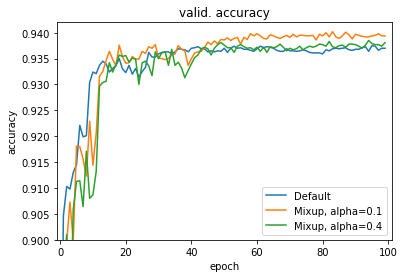

In [36]:
plot_history(hists, attribute='val_acc', axis=(-1,101,0.9,0.942), loc='lower right')

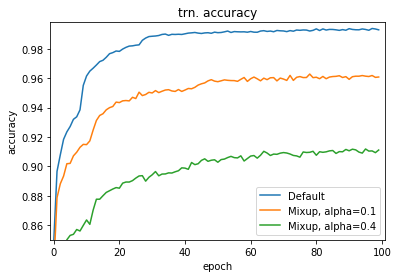

In [32]:
plot_history(hists, attribute='acc', axis=(-1,101,0.85,0.998), loc='lower right')

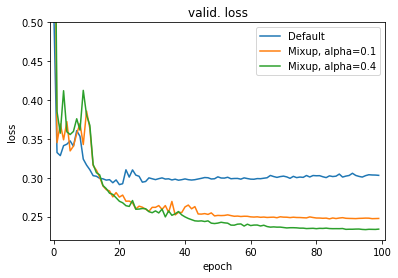

In [28]:
plot_history(hists, attribute='val_loss', axis=(-1,101,0.22,0.5), loc='upper right')

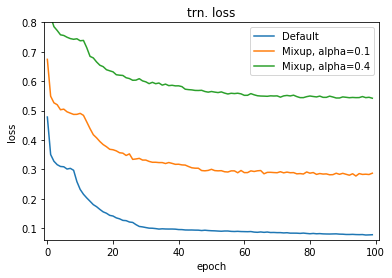

In [35]:
plot_history(hists, attribute='loss', axis=(-1,101,0.06,0.8), loc='upper right')